In [2]:
import gc
import time
from contextlib import contextmanager
import warnings
import pickle
import numpy as np
import pandas as pd

from sklearn.metrics import (
    f1_score,classification_report,
    roc_auc_score,confusion_matrix,roc_curve,auc,
    fbeta_score, accuracy_score, recall_score
) # evaluation metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

import mlflow
from mlflow.models import infer_signature
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from multiprocessing import cpu_count
from sklearn.model_selection import RepeatedStratifiedKFold
import pickle
import seaborn as sns
import matplotlib.pyplot as plt


warnings.simplefilter(action='ignore', category=FutureWarning)

# Preprocessing

In [1]:
# HOME CREDIT DEFAULT RISK COMPETITION
PATH_FILE = 'input'

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = False):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application(num_rows = None, nan_as_category = False):
    # Read data
    df = pd.read_csv(f'{PATH_FILE}/application_train.csv', nrows= num_rows)
    print(f"Train samples: {len(df)}")

    # Join with application_test
    test_df = pd.read_csv(f'{PATH_FILE}/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = pd.concat([df,test_df]).reset_index()

    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']: 
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH'] # taux de jours employés par rapport à l'âge
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT'] # 
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS'] # revenu par membre du foyer
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL'] # part de l'annuité par rapport au salaire total du client
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT'] # taux de remboursement / taux de paiement(somme remboursée) par rapport à la somme finale du crédit par année (previous application)
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = False):
    bureau = pd.read_csv(f'{PATH_FILE}/bureau.csv', nrows = num_rows)
    bb = pd.read_csv(f'{PATH_FILE}/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
   
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = False):
    prev = pd.read_csv(f'{PATH_FILE}/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= False)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = False):
    pos = pd.read_csv(f'{PATH_FILE}/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= False)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = False):
    ins = pd.read_csv(f'{PATH_FILE}/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = False):
    cc = pd.read_csv(f'{PATH_FILE}/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= False)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

def preprocessing(num_rows=30000, debug = False):
    num_rows = num_rows if debug else None
    df = application(num_rows = num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    print(f"df shape after preprocessing : {df.shape}")
    return df

if __name__ == "__main__":
    with timer("Full Preprocessing run"):
        df = preprocessing(debug = False)

Train samples: 307511
Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 112)
Process bureau and bureau_balance - done in 33s
Previous applications df shape: (338857, 233)
Process previous_applications - done in 39s
Pos-cash balance df shape: (337252, 17)
Process POS-CASH balance - done in 20s
Installments payments df shape: (339587, 26)
Process installments payments - done in 36s
Credit card balance df shape: (103558, 136)
Process credit card balance - done in 24s
df shape after preprocessing : (356251, 772)
Full Preprocessing run - done in 164s


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356251 entries, 0 to 356254
Columns: 772 entries, index to CC_COUNT
dtypes: bool(133), float64(582), int64(43), object(14)
memory usage: 1.7+ GB


In [2]:
ids_columns = [f for f in df.columns if f in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
numerical_feats = [c for c in df.select_dtypes(include=['number']).columns if c not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
categorical_feats = [c for c in df.select_dtypes(include=['object']).columns if c not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
bool_feats = [c for c in df.select_dtypes(include=['bool']).columns if c not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

## Transformation des booléens en Int

In [4]:
# Transformation des booleen en int
df[bool_feats] = df[bool_feats].astype(int)
df[categorical_feats] = df[categorical_feats].replace({True: 1, False: 0})


## Missing Values

In [6]:
numerical_feats = [c for c in df.select_dtypes(include=['number']).columns if c not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

In [7]:
# Identification des variables numériques  avec plus de 60% de NA
df_numeric= df[numerical_feats]
missings =df_numeric.loc[:,df_numeric.isna().mean() >= 0.6]
highly_missing_features = missings.columns
missings.columns

Index(['OWN_CAR_AGE', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'FLOORSMIN_AVG',
       'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'FLOORSMIN_MODE', 'LIVINGAPARTMENTS_MODE',
       ...
       'CC_NAME_CONTRACT_STATUS_Sent proposal_MAX',
       'CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN',
       'CC_NAME_CONTRACT_STATUS_Sent proposal_SUM',
       'CC_NAME_CONTRACT_STATUS_Sent proposal_VAR',
       'CC_NAME_CONTRACT_STATUS_Signed_MIN',
       'CC_NAME_CONTRACT_STATUS_Signed_MAX',
       'CC_NAME_CONTRACT_STATUS_Signed_MEAN',
       'CC_NAME_CONTRACT_STATUS_Signed_SUM',
       'CC_NAME_CONTRACT_STATUS_Signed_VAR', 'CC_COUNT'],
      dtype='object', length=206)

In [8]:
# Suppression des features avec beaucoup de NA
df_numeric.drop(highly_missing_features,axis=1,inplace=True)

C:\Users\fly\AppData\Local\Temp\ipykernel_25780\2117508509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric.drop(highly_missing_features,axis=1,inplace=True)


In [9]:
df_numeric.shape

(356251, 563)

## Imputation par la médiane

In [10]:
df_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\fly\AppData\Local\Temp\ipykernel_25780\563139981.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)


## Split target et df

In [11]:
ids = df[ids_columns]

In [ ]:
df_all = pd.concat([ids, df_numeric], axis=1)
target = df_all['TARGET']

## df_all numeric

In [16]:
df_all_numeric = df_all[[c for c in df_all if c not in ['TARGET']]]

In [19]:
from sklearn.impute import SimpleImputer
numeric_imputer = SimpleImputer(strategy='median')
imputed_numeric_features_all = numeric_imputer.fit_transform(df_all_numeric)

In [36]:
df_all_clean = pd.DataFrame(imputed_numeric_features_all, columns=df_all_numeric.columns).reset_index(drop = True)

In [37]:
df_all_clean

,index,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,0.0,100002.0,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19.0
1,1.0,100003.0,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25.0
2,2.0,100004.0,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3.0
3,3.0,100006.0,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,...,62947.088438,1007153.415,2482.920,691786.890,62947.088438,1007153.415,-12.0,-271.625000,-4346.0,16.0
4,4.0,100007.0,0.0,0.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,...,12666.444545,835985.340,0.180,22678.785,12214.060227,806127.975,-14.0,-1032.242424,-68128.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356246,48739.0,456221.0,1.0,0.0,0.0,0.0,121500.0,412560.0,17473.5,270000.0,...,91036.455000,273109.365,14222.430,244664.505,91036.455000,273109.365,-599.0,-630.333333,-1891.0,3.0
356247,48740.0,456222.0,1.0,0.0,1.0,2.0,157500.0,622413.0,31909.5,495000.0,...,8086.162192,590289.840,2.700,14571.765,7771.447603,567315.675,-56.0,-992.712329,-72468.0,73.0
356248,48741.0,456223.0,1.0,1.0,0.0,1.0,202500.0,315000.0,33205.5,315000.0,...,23158.991250,185271.930,12640.950,81184.005,23158.991250,185271.930,-33.0,-586.375000,-4691.0,8.0
356249,48742.0,456224.0,0.0,0.0,1.0,0.0,225000.0,450000.0,25128.0,450000.0,...,17269.234138,500807.790,5519.925,23451.705,17269.234138,500807.790,-13.0,-924.965517,-26824.0,29.0


In [43]:
df_final = pd.concat([df_all_clean.reset_index(drop=True), target.reset_index(drop=True)], axis=1)


In [44]:
df_final

,index,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT,TARGET
0,0.0,100002.0,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,...,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19.0,1.0
1,1.0,100003.0,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,...,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25.0,0.0
2,2.0,100004.0,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,...,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3.0,0.0
3,3.0,100006.0,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,...,1007153.415,2482.920,691786.890,62947.088438,1007153.415,-12.0,-271.625000,-4346.0,16.0,0.0
4,4.0,100007.0,0.0,0.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,...,835985.340,0.180,22678.785,12214.060227,806127.975,-14.0,-1032.242424,-68128.0,66.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356246,48739.0,456221.0,1.0,0.0,0.0,0.0,121500.0,412560.0,17473.5,270000.0,...,273109.365,14222.430,244664.505,91036.455000,273109.365,-599.0,-630.333333,-1891.0,3.0,NaN
356247,48740.0,456222.0,1.0,0.0,1.0,2.0,157500.0,622413.0,31909.5,495000.0,...,590289.840,2.700,14571.765,7771.447603,567315.675,-56.0,-992.712329,-72468.0,73.0,NaN
356248,48741.0,456223.0,1.0,1.0,0.0,1.0,202500.0,315000.0,33205.5,315000.0,...,185271.930,12640.950,81184.005,23158.991250,185271.930,-33.0,-586.375000,-4691.0,8.0,NaN
356249,48742.0,456224.0,0.0,0.0,1.0,0.0,225000.0,450000.0,25128.0,450000.0,...,500807.790,5519.925,23451.705,17269.234138,500807.790,-13.0,-924.965517,-26824.0,29.0,NaN


In [45]:
df_train_clean = df_final[df_final['TARGET'].notnull()]
df_test_clean = df_final[df_final['TARGET'].isnull()]

In [48]:
df_train_clean.shape, df_test_clean.shape

((307507, 566), (48744, 566))

# Export df clean

In [49]:
df_train_clean.to_csv('data/df_train_clean.csv', encoding='utf-8', index=None)
df_test_clean.to_csv('data/df_test_clean.csv', encoding='utf-8', index=None)

# Modèle

In [3]:
df_train_clean = pd.read_csv('data/df_train_clean.csv')
df_test_clean = pd.read_csv('data/df_test_clean.csv')

In [14]:
data_sample = df_train_clean[:2].copy()
data_sample.to_csv('test/data_sample.csv', index=False)


In [30]:
def get_model_metrics(model_name: str, y_test, y_pred, y_prob):
    metrics = {
        "model_name": model_name,
        "f2_score": fbeta_score(y_test, y_pred, beta=2),
        "accuracy_score": accuracy_score(y_test, y_pred), # Utilisation de accuracy_score
        "recall": recall_score(y_true=y_test, y_pred=y_pred),
        "f1_score": f1_score(y_true=y_test, y_pred=y_pred),
        "roc_auc": roc_auc_score(y_test, y_prob),
    }
    print(f"F1-score: {metrics['f1_score']}")
    print(f"F2-score : {metrics['f2_score']}")
    print(f"ROC AUC : {metrics['roc_auc']}")
    print(f"accuracy_score : {metrics['accuracy_score']}")
    print(f"Recall : {metrics['recall']}")
    print('*' * 20)
    return metrics

In [31]:
def log_model_mlflow(x_train, metrics_dict, model, model_name, tag_model:None):
    with mlflow.start_run():
        params = {
            "nthread":6,
            "n_estimators":10000,
            "learning_rate":0.02,
            "num_leaves":34,
            "colsample_bytree":0.9497036,
            "subsample":0.8715623,
            "max_depth":8,
            "reg_alpha":0.041545473,
            "reg_lambda":0.0735294,
            "min_split_gain":0.0222415,
            "min_child_weight":39.3259775,
            "silent":-1,
            "verbose":-1
        }
        mlflow.log_params(params)

        # Log the metric
        # mlflow.log_metric(metric_name, metric)
        mlflow.log_metric('f2_score', metrics_dict['f2_score'])
        mlflow.log_metric('roc_auc', metrics_dict['roc_auc'])

        # Set a tag that we can use to remind ourselves what this run was for
        mlflow.set_tag("Training Info", model_name)
        mlflow.set_tag("Model Info", tag_model)

        # Infer the model signature
        signature = infer_signature(x_train, model.predict(x_train))
        # Log the model
        model_info = mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path=model_name,
            signature=signature,
            registered_model_name=model_name,
        )

## Setup Mlflow

In [35]:
# Set MLflow Experiment ---------------------------------------------------------
mlflow.set_tracking_uri(uri="http://localhost:8080")
# mlflow.set_experiment("credit_scoring_experiment__80_features")
# mlflow.set_experiment("credit_scoring_experiment__80FeaturesAllRows")
mlflow.set_experiment("credit_scoring_experiment__500FeaturesAllRows")

<Experiment: artifact_location='mlflow-artifacts:/683266355842499579', creation_time=1734524339731, experiment_id='683266355842499579', last_update_time=1734524339731, lifecycle_stage='active', name='credit_scoring_experiment__500FeaturesAllRows', tags={}>

## Train data

In [23]:
feats = [f for f in df_train_clean.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = df_train_clean[feats]
y = df_train_clean['TARGET']

## Splitting Train and Test Sets

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=27)

## Scaling

In [25]:
# Scaling data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modèles Simples

## Dummy Classifier

In [32]:
# Scaling data
dummy_clf = DummyClassifier(strategy="most_frequent").fit(X_train_scaled, y_train)
y_pred__dummy = dummy_clf.predict(X_test_scaled)
y_pred_train__dummy = dummy_clf.predict(X_train_scaled)
# Prédire les probabilités
y_prob__dummy = dummy_clf.predict_proba(X_test_scaled)[:, 1]
y_prob_train__dummy = dummy_clf.predict_proba(X_train_scaled)[:, 1]

print('*' * 20)
print('Metrics Test')
metrics_dummy = get_model_metrics('DummyClassifier__test', y_test, y_pred__dummy, y_prob__dummy)
print('Metrics Train')
metrics_dummy__train = get_model_metrics('DummyClassifier__train', y_train, y_pred_train__dummy, y_prob_train__dummy)

********************
Metrics Test
F1-score: 0.0
F2-score : 0.0
ROC AUC : 0.5
accuracy_score : 0.9192736449133031
Recall : 0.0
********************
Metrics Train
F1-score: 0.0
F2-score : 0.0
ROC AUC : 0.5
accuracy_score : 0.9192689589385596
Recall : 0.0
********************


In [36]:
log_model_mlflow(X_train_scaled, metrics_dummy, dummy_clf, "DummyClassifier", tag_model="Baseline")

Registered model 'DummyClassifier' already exists. Creating a new version of this model...
2024/12/18 22:59:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DummyClassifier, version 7
Created version '7' of model 'DummyClassifier'.
2024/12/18 22:59:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run inquisitive-lark-897 at: http://localhost:8080/#/experiments/683266355842499579/runs/460f909e936d4d9ebbecf24392c261d0.
2024/12/18 22:59:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/683266355842499579.


## Logistic Regression

In [37]:
# Logistic Regression
lr = LogisticRegression(class_weight='balanced', random_state=0).fit(X_train_scaled, y_train)
y_pred__lr = lr.predict(X_test_scaled)
y_pred_train__lr = lr.predict(X_train_scaled)
y_prob__lr = lr.predict_proba(X_test_scaled)[:,1]
y_prob_train__lr = lr.predict_proba(X_train_scaled)[:,1]

print('*' * 20)
print('Metrics Test')
metrics_LR = get_model_metrics(f'LogisticRegression__test', y_test, y_pred__lr, y_prob__lr)
print('Metrics Train')
metrics_LR_train = get_model_metrics(f'LogisticRegression__train', y_train, y_pred_train__lr, y_prob_train__lr)

c:\Users\fly\Documents\Data_Disk_D\Data\fly\Mes documents\FTTH Data\formation_oc\scoring_model\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


********************
Metrics Test
F1-score: 0.2738226318935414
F2-score : 0.4317032040472175
ROC AUC : 0.7639199750882057
accuracy_score : 0.6997411449458225
Recall : 0.7012568482114083
********************
Metrics Train
F1-score: 0.2734554135125797
F2-score : 0.43136594260345645
ROC AUC : 0.7688513775536185
accuracy_score : 0.6991154663313532
Recall : 0.7013803104355766
********************


In [38]:
log_model_mlflow(X_train_scaled, metrics_LR, lr, "LogisticRegression", tag_model = None)

Registered model 'LogisticRegression' already exists. Creating a new version of this model...
2024/12/18 22:59:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression, version 4
Created version '4' of model 'LogisticRegression'.
2024/12/18 22:59:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run amazing-fly-63 at: http://localhost:8080/#/experiments/683266355842499579/runs/46f6d006885a4f75bd22e090a2294f16.
2024/12/18 22:59:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/683266355842499579.


## Random Forest

In [41]:
# Random Forest
rf = RandomForestClassifier(class_weight='balanced', random_state=42).fit(X_train_scaled, y_train)
y_pred__rf = rf.predict(X_test_scaled)
y_pred_train__rf = rf.predict(X_train_scaled)
y_prob__rf = rf.predict_proba(X_test_scaled)[:,1]
y_prob_train__rf = rf.predict_proba(X_train_scaled)[:,1]

print('*' * 20)
print('Metrics Test')
metrics_RF = get_model_metrics(f'RandomForestClassifier__test', y_test, y_pred__rf, y_prob__rf)
print('Metrics Train')
metrics_RF_train = get_model_metrics(f'RandomForestClassifier__train', y_train, y_pred_train__rf, y_prob_train__rf)


********************
Metrics Test
F1-score: 0.002571933772705353
F2-score : 0.001610370787873908
ROC AUC : 0.726609552072673
accuracy_score : 0.9192866527049702
Recall : 0.0012890750886239124
********************
Metrics Train
F1-score: 0.9998119846364588
F2-score : 0.9996992093502922
ROC AUC : 1.0
accuracy_score : 0.9999696483545072
Recall : 0.9996240399591815
********************


In [42]:
log_model_mlflow(X_train_scaled, metrics_RF, rf, "RandomForestClassifier", tag_model = None)

Registered model 'RandomForestClassifier' already exists. Creating a new version of this model...
2024/12/18 23:08:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForestClassifier, version 6
Created version '6' of model 'RandomForestClassifier'.
2024/12/18 23:08:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run brawny-duck-338 at: http://localhost:8080/#/experiments/683266355842499579/runs/25be865f243e41b28d36c28ee603c96f.
2024/12/18 23:08:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/683266355842499579.


## LGBM Classifier

In [39]:
# LGBM Classifier
clf = LGBMClassifier(objective= 'binary', class_weight="balanced").fit(X_train_scaled, y_train)
y_pred__clf = clf.predict(X_test_scaled)
y_pred_train__clf = clf.predict(X_train_scaled)
y_prob__clf = clf.predict_proba(X_test_scaled)[:,1]
y_prob_train__clf = clf.predict_proba(X_train_scaled)[:,1]

print('*' * 20)
print('Metrics Test')
metrics_LGBM = get_model_metrics(f'LGBMClassifier__test', y_test, y_pred__clf, y_prob__clf)
print('Metrics Train')
metrics_LGBM_train = get_model_metrics(f'LGBMClassifier__train', y_train, y_pred_train__clf, y_prob_train__clf)

[LightGBM] [Info] Number of positive: 18619, number of negative: 212011
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.989721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61665
[LightGBM] [Info] Number of data points in the train set: 230630, number of used features: 539
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
********************
Metrics Test
F1-score: 0.29126806431915325
F2-score : 0.44629491017964074
ROC AUC : 0.7812495039436279
accuracy_score : 0.7282412164886767
Recall : 0.691749919432807
********************
Metrics Train
F1-score: 0.3231058234189105
F2-score : 0.49376444060908053
ROC AUC : 0.8315420527275655
accuracy_score : 0.7422061310323895
Recall : 0.7621247113163973
********************


In [40]:
log_model_mlflow(X_train_scaled, metrics_LGBM, clf, "LGBMClassifier", tag_model = None)

Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
2024/12/18 23:00:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LGBMClassifier, version 6
Created version '6' of model 'LGBMClassifier'.
2024/12/18 23:00:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run resilient-quail-820 at: http://localhost:8080/#/experiments/683266355842499579/runs/954464b7e4b24ae1b2f73fdcea68dabc.
2024/12/18 23:00:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/683266355842499579.


In [62]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X_train.columns)), columns=['Value','Feature'])
top_feature = feature_imp.sort_values(by="Value", ascending=False)[:20]

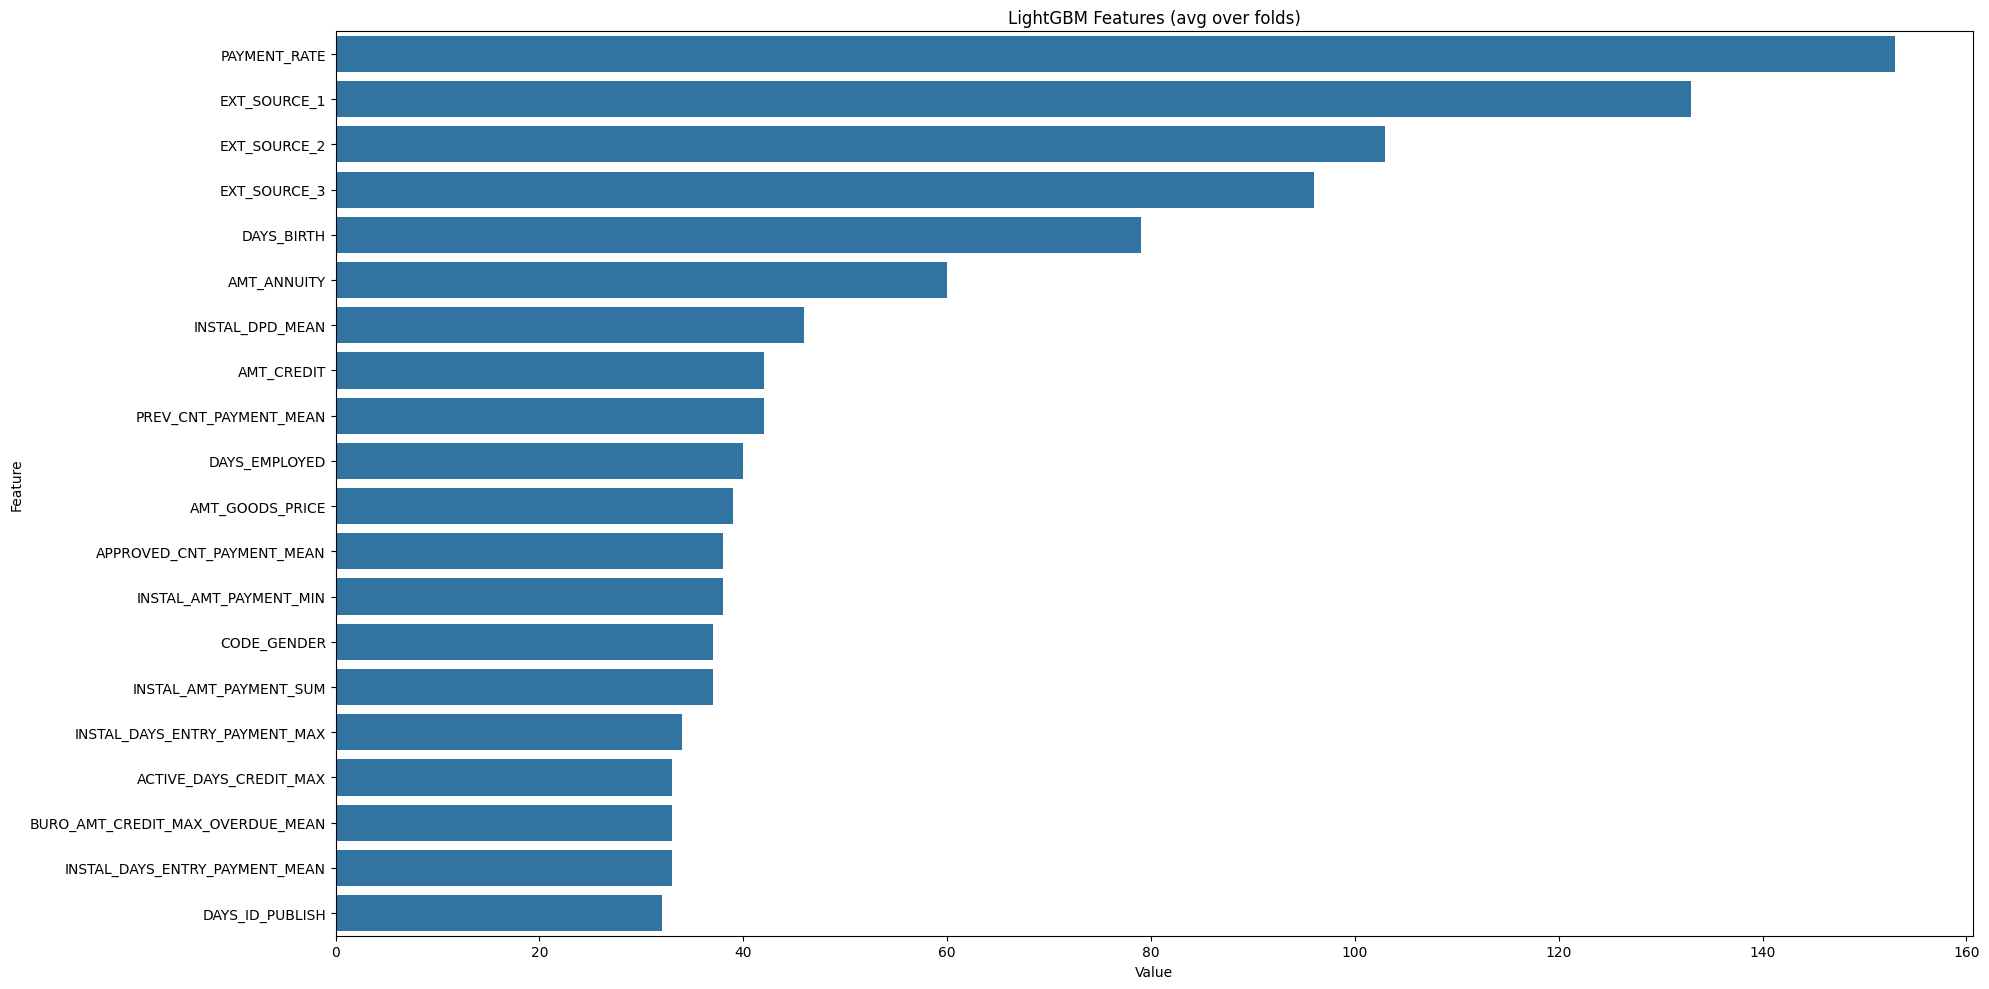

In [63]:
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=top_feature.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

## Recap Métriques Modèles

In [43]:
df_model_metrics = pd.DataFrame([metrics_dummy])
# df_metrics = pd.concat([df_metrics, pd.DataFrame([metrics_train])], join='inner', ignore_index=True)

list_metrics = [
    metrics_dummy__train,
    metrics_LR,
    metrics_LR_train,
    metrics_RF,
    metrics_RF_train,
    metrics_LGBM,
    metrics_LGBM_train,
]

for m in list_metrics :
    df_model_metrics = pd.concat([df_model_metrics, pd.DataFrame([m])], join='inner', ignore_index=True)

In [44]:
df_model_metrics.sort_values('roc_auc', ascending=False)

,model_name,f2_score,accuracy_score,recall,f1_score,roc_auc
5,RandomForestClassifier__train,0.999699,0.999970,0.999624,0.999812,1.000000
7,LGBMClassifier__train,0.493764,0.742206,0.762125,0.323106,0.831542
6,LGBMClassifier__test,0.446295,0.728241,0.691750,0.291268,0.781250
3,LogisticRegression__train,0.431366,0.699115,0.701380,0.273455,0.768851
2,LogisticRegression__test,0.431703,0.699741,0.701257,0.273823,0.763920
4,RandomForestClassifier__test,0.001610,0.919287,0.001289,0.002572,0.726610
0,DummyClassifier__test,0.000000,0.919274,0.000000,0.000000,0.500000
1,DummyClassifier__train,0.000000,0.919269,0.000000,0.000000,0.500000


# Modèle Tuning

In [64]:
# Create the pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    # ('s', SMOTE(random_state=1)),
    ('m', LGBMClassifier(objective= 'binary', class_weight='balanced'))
])

# Define the parameter grid
param_grid = {
    # 's__sampling_strategy': ['auto', 0.5],  # SMOTE : ratio entre l'échantillone dans la classe minoritaire et la classe majoritaire
    'm__max_iter': [200, 300], # Nombre maximum d'itération pour que le solver converge
    'm__n_estimators': [500, 1000],
    'm__learning_rate': [0.01, 0.02]
}

# Perform random search
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=1, random_state=1)

# Effectuer une recherche par grille
grid_search_LGBM = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',  # Métrique d'évaluation
    cv=cv,
    verbose=0,
    n_jobs=cpu_count()
)

# Lancer la recherche sur les données (X, y)
lgbm_tuned_fitted = grid_search_LGBM.fit(X_train_scaled, y_train)
y_prob__lgbm_tuned = lgbm_tuned_fitted.predict_proba(X_test_scaled)[:,1]
y_pred__lgbm_tuned = lgbm_tuned_fitted.predict(X_test_scaled)

y_prob_train__lgbm_tuned = lgbm_tuned_fitted.predict_proba(X_train_scaled)[:,1]
y_pred_train__lgbm_tuned = lgbm_tuned_fitted.predict(X_train_scaled)
# Afficher les meilleurs paramètres
print("Meilleurs paramètres :", grid_search_LGBM.best_params_)
print("Meilleur score AUC :", grid_search_LGBM.best_score_)

print('*' * 20)
print('Metrics Test')
metrics_LGBM_tuned = get_model_metrics(f'LGBMClassifier_tuned__test', y_test, y_pred__lgbm_tuned, y_prob__lgbm_tuned)
print('Metrics Train')
metrics_LGBM_train_tuned = get_model_metrics(f'LGBMClassifier_tuned__train', y_train, y_pred_train__lgbm_tuned, y_prob_train__lgbm_tuned)


best_LGBM = grid_search_LGBM.best_estimator_
# Print the best parameters and best score
print("Best Parameters:", grid_search_LGBM.best_params_)
print("Best Score:", grid_search_LGBM.best_score_)

c:\Users\fly\Documents\Data_Disk_D\Data\fly\Mes documents\FTTH Data\formation_oc\scoring_model\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=300, max_iter=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Info] Number of positive: 18619, number of negative: 212011
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.590667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61665
[LightGBM] [Info] Number of data points in the train set: 230630, number of used features: 539
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Meilleurs paramètres : {'m__learning_rate': 0.02, 'm__max_iter': 300, 'm__n_estimators': 500}
Meilleur score AUC : 0.7770885794063193
********************
Metrics Test
F1-score: 0.2856481634542269
F2-score : 0.6768418391011432
ROC AUC : 0.7770590773595217
accuracy_score : 0.7189406454466225
Recall : 0.6961005478569127
********************
Metrics Train
F1-score: 0.30531311187070653
F2-scor

In [ ]:
# Save to file in the current working directory
pkl_filename = "model_LGBM.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(best_LGBM._final_estimator, file)

In [65]:
log_model_mlflow(X_train_scaled, metrics_LGBM_tuned, lgbm_tuned_fitted, "LGBMClassifierTuned", tag_model="Model Tuned")

Registered model 'LGBMClassifierTuned' already exists. Creating a new version of this model...
2024/12/18 15:17:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LGBMClassifierTuned, version 2
Created version '2' of model 'LGBMClassifierTuned'.
2024/12/18 15:17:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run puzzled-shad-272 at: http://localhost:8080/#/experiments/683266355842499579/runs/c4c2ccdd4596426db037f2735be24b47.
2024/12/18 15:17:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/683266355842499579.


## Evaluation

In [27]:
def roc_curve__confusion_matrix(model):
    from sklearn.metrics import roc_curve, auc
    # y_prob_test = model.predict_proba(X_test)[:, 1]
    # y_prob_train  = model.predict_proba(X_train)[:, 1]
    # prediction=model.predict(X_test)

    y_prob_test = model.predict_proba(X_test_scaled)[:, 1]
    y_prob_train  = model.predict_proba(X_train_scaled)[:, 1]
    prediction=model.predict(X_test_scaled)
    # calculate tpr ,fpr
    fpr_test , tpr_test , thresholds = roc_curve(y_test, y_prob_test)
    fpr_train , tpr_train , thresholds1 = roc_curve(y_train, y_prob_train)

    # calculate AUC score
    roc_auc_test  = auc(fpr_test, tpr_test)
    roc_auc_train  = auc(fpr_train ,tpr_train)


    # calculate confusion matrix for test set
    confusion_matrix_test = confusion_matrix(y_test, prediction)

    # create subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # plot ROC curves on the first subplot
    axs[0].plot(fpr_train, tpr_train, color='green', label='ROC curve train (AUC = %0.2f)' % roc_auc_train)
    axs[0].plot(fpr_test, tpr_test, color='blue', label='ROC curve test (AUC = %0.2f)' % roc_auc_test)
    axs[0].plot([0, 1], [0, 1], color='red', linestyle='--')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('Receiver Operating Characteristic (ROC) Curve')
    axs[0].legend(loc="lower right")

    sns.set(font_scale=1.4)
    sns.heatmap(confusion_matrix_test, annot=True, fmt='g', cmap='Blues', ax=axs[1])
    axs[1].set_xlabel('Predicted label')
    axs[1].set_ylabel('True label')
    axs[1].set_title('Confusion Matrix (Test Set)model');

    plt.tight_layout()
    plt.show()

In [ ]:
roc_curve__confusion_matrix(best_LGBM._final_estimator)

In [15]:
import pickle
model = pickle.load(open("model_LGBM_Tuned_500cols.pkl", "rb"))
model = model._final_estimator

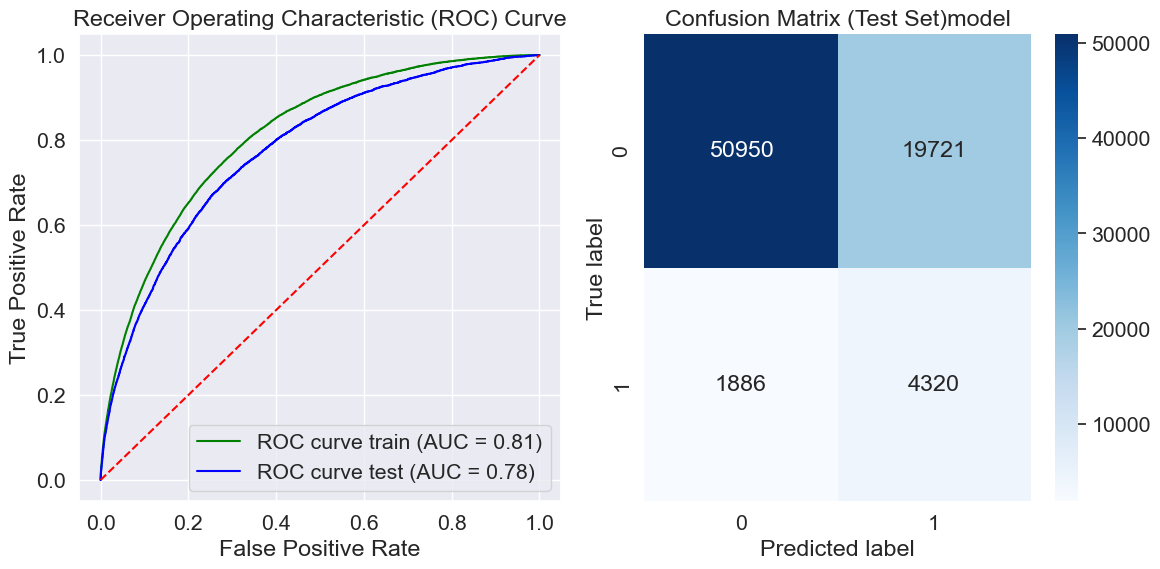

In [ ]:
roc_curve__confusion_matrix(model)

## Feature Importance

In [73]:
def feature_importance(model):  
    feature_imp = pd.DataFrame(sorted(zip(model._final_estimator.feature_importances_,X_train.columns)), columns=['Value','Feature'])
    top_feature = feature_imp.sort_values(by="Value", ascending=False)[:20]

    # plot
    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=top_feature.sort_values(by="Value", ascending=False))
    plt.title('TOP 20 Features')
    plt.tight_layout()
    plt.show()

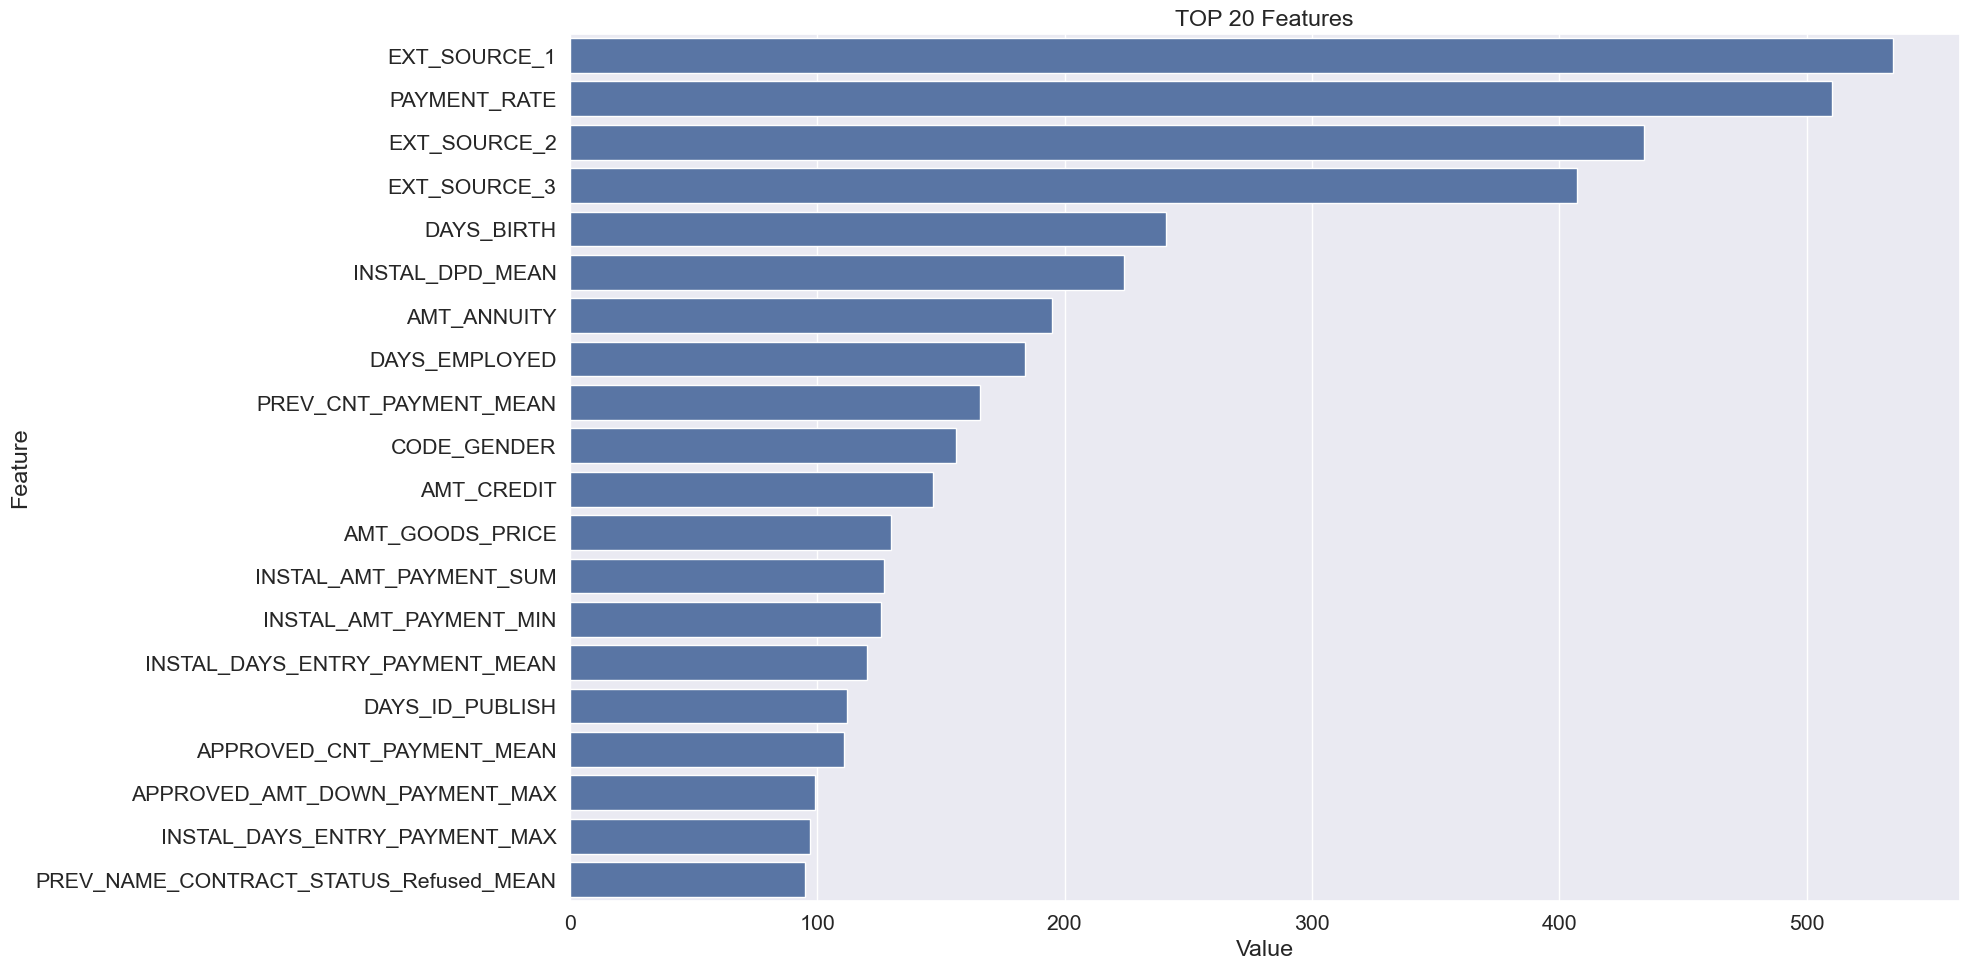

In [74]:
feature_importance(best_LGBM)